In [1]:
# Implementing broken power law + three parameter power law
# Fit the broken power law to this set of values
%load_ext autoreload 
%autoreload 2
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from scipy.stats import ttest_ind

sns.set_style('white')
sys.path.insert(0, '../../')
from curve_models import NLLS_three_param, power_law_three_param, power_law_exp_three_param
from curve_models import NLLS_w, power_law
from curve_models import BrokenCurve, power_law

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

expmt_dict = {'gl-tiny': '0.1_5_False_uniform_30_0.5_0.5_1880_9400_94001' + '/',
                'ml-20m-uniform': '0.1_5_False_uniform_30_0.5_0.5_20000_100000_1000001' + '/', 
                'ml-20m-tiny':'0.1_5_False_uniform_30_0.5_0.5_5250_21000_213973' + '/',
                'gl': '0.1_5_False_uniform_30_0.5_0.5_5800_29000_290001' +'/'}
dataset_names = ['gl', 'gl-tiny', 'ml-20m-uniform', 'ml-20m-tiny']
dataset_dict =  {'gl':'GoogleLocal-L', 'gl-tiny':'GoogleLocal-S', 
                 'ml-20m-uniform': 'MovieLens-L', 'ml-20m-tiny': 'MovieLens-S'}

# Default true slope approximation: smoothed over 4 samples
# Alternate true slope approximation: smoothed over 2 samples
alternate_slope_approx = False

In [2]:
from tqdm.notebook import tqdm
# Plot true slope
n_runs = 5
slope_dicts = []
hue_order = ['True', 'NLS_initial', 'NLS_w', 'NLS_power_law_3P', 'NLS_power_law_exp_3P', 'broken']
for dataset_name in tqdm(dataset_names):
    expmt = expmt_dict[dataset_name]
    results_dir = "../../results/forecasting/" + dataset_name + "/Random/"
    results_path = results_dir + expmt

    all_ss = np.loadtxt(results_path + 'sample_sizes')
    all_mses = np.loadtxt(results_path + 'mses')
    data = pd.read_csv(results_path + 'results_df')
    n_init = data['n_init'].iloc[0]
    n_max = all_ss[0][-1]
    for r in range(n_runs):
        ss = all_ss[r]
        mses = all_mses[r]
        for i in range(1, len(ss)-1):
            # Skip sample sizes within initially acquired set,
            # since no data collection decision is necessary
            if ss[i] < n_init:
                continue
                
            # Record the % of data collected 
            pct = ss[i]/n_max
            
            # Approximate true slope at sample i 
            slope_before = (mses[i] - mses[i-1])/(ss[i] - ss[i-1])
            slope_after = (mses[i+1] - mses[i])/(ss[i+1] - ss[i])
            slope = .5*(slope_before+slope_after)
            if i-2 > 0 and i+2 < len(mses) and not alternate_slope_approx:
                slope = (mses[i+2] - mses[i-2] )/(ss[i+2] -  ss[i-2])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'True',
                               'dataset': dataset_name, 'pct': pct})
            
            # Naive: approximate slope with previous two subsamples
            slope = (mses[i] - mses[i-1])/(ss[i] - ss[i-1])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'Naive',
                               'dataset': dataset_name, 'pct': pct})

            # 2P-PL-Init
            nlls = NLLS_w(power_law)
            stop_pt = min(np.where(ss > n_init)[0])
            nlls.fit(ss[:stop_pt], mses[:stop_pt])
            slope = nlls.slope(ss[i])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'NLS_initial',
                               'dataset': dataset_name, 'pct': pct})

            nlls_w = NLLS_w(power_law)
            nlls_w.fit(ss[:i+1], mses[:i+1])
            slope = nlls_w.slope(ss[i])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'NLS_w',
                               'dataset': dataset_name, 'pct': pct})

            nlls_3p = NLLS_three_param(power_law_three_param, "power_law_3p")
            nlls_3p.fit(ss[:i+1], mses[:i+1]) 
            slope = nlls_3p.slope(ss[i])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'NLS_power_law_3P',
                               'dataset': dataset_name, 'pct': pct})

            nlls_3p = NLLS_three_param(power_law_three_param, "power_law_3p")
            nlls_3p.fit(ss[:i+1], mses[:i+1]) 
            slope = nlls_3p.slope(ss[i])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'NLS_power_law_3P',
                               'dataset': dataset_name, 'pct': pct})

            nlls_exp_3p = NLLS_three_param(power_law_exp_three_param, "power_law_exp_3p")
            nlls_exp_3p.fit(ss[:i+1], mses[:i+1])
            slope = nlls_exp_3p.slope(ss[i])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'NLS_power_law_exp_3P', 
                               'dataset': dataset_name, 'pct': pct})

            broken = BrokenCurve(power_law, "3p-power-law")
            broken.fit(ss[:i+1], mses[:i+1])
            slope = broken.slope(ss[i])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'broken',
                                'dataset': dataset_name, 'pct': pct})
        #slopes.append(slope_before)
slope_df = pd.DataFrame(slope_dicts)
slope_df.to_csv('../../results/slopes_df.csv')

/local/divyas/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


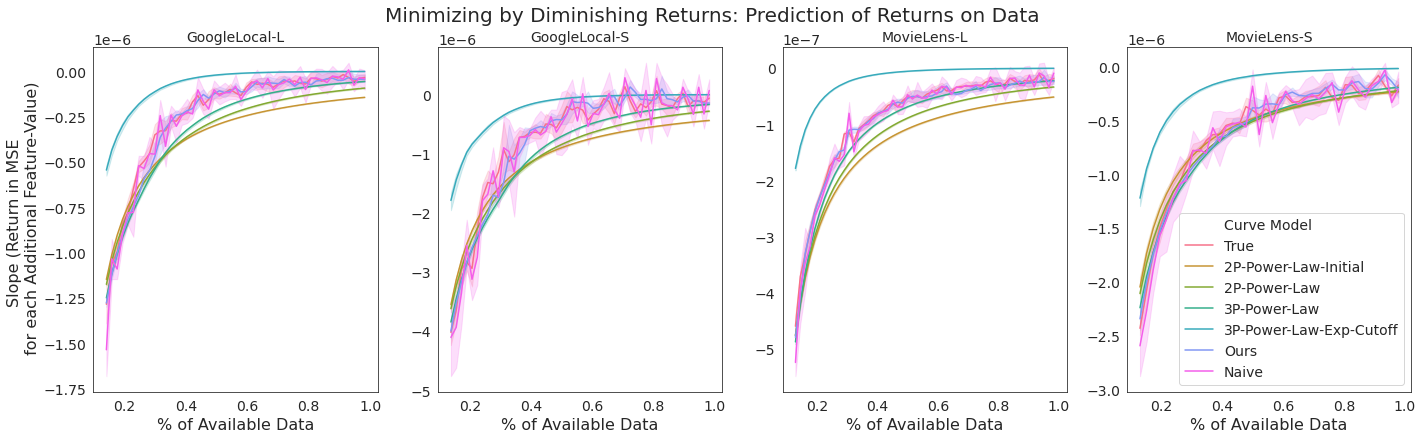

In [4]:
hue_order = ['True', 'NLS_initial', 'NLS_w', 'NLS_power_law_3P', 
             'NLS_power_law_exp_3P', 'broken', 'Naive']
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

colors = sns.color_palette("colorblind")
sns.set_palette([colors[3], colors[1], colors[0], colors[8], colors[9], colors[2]])
dataset_titles = {'gl': 'GoogleLocal-L', 'gl-tiny': 'GoogleLocal-S', 'ml-20m-tiny': 'MovieLens-S',
                 'ml-20m-uniform': 'MovieLens-L'}
all_data_dfs  = []
for i,dataset_name in enumerate(dataset_names):
    ax = axs[i]
    data_df = slope_df[slope_df['dataset'] == dataset_name]
    sns.lineplot(x='pct', y='slope', hue='cm', hue_order=hue_order, data=data_df, 
                ax = ax)
    ax.set_xlabel("% of Available Data")
    ax.set_title(dataset_titles[dataset_name])
    if i == 0:
        ax.set_ylabel("Slope (Return in MSE \n for each Additional Feature-Value)")
    else:
        ax.set_ylabel("")
    if i != 3:
        ax.get_legend().remove()
    else:
        L=ax.get_legend()
        new_names = ['Curve Model', 'True', '2P-Power-Law-Initial', '2P-Power-Law', '3P-Power-Law', 
                     '3P-Power-Law-Exp-Cutoff', 'Ours']
        for i,new in enumerate(new_names):
            L.get_texts()[i].set_text(new)
    all_data_dfs.append(data_df)
plt.tight_layout()

all_data_df = pd.concat(all_data_dfs)

suptitle = plt.suptitle("Minimizing by Diminishing Returns: Prediction of Returns on Data", y=1.02)
plt.savefig("../../figs/diminishing_returns_fig", bbox_inches='tight',bbox_extra_artists=[suptitle])


In [5]:
cols = ['t', 'NLS_initial',  'NLS_w', 'NLS_power_law_3P', 'NLS_power_law_exp_3P', 'broken', 'Naive', 'True']
methods = ['NLS_initial',  'NLS_w', 'NLS_power_law_3P', 'NLS_power_law_exp_3P', 'broken', 'Naive', 'True']
final_tables = []
for dataset in dataset_names:
    # pcts collected for different thresholds
    #thresholds = [-.5e-6, -.4e-6, -.3e-6, -.25e-6, -.2e-6, -.15e-6,-.1e-6,-.05e-6]
    thresholds = [-.5e-6,   -.2e-6, -.05e-6]
    threshold_tables = []
    for t in thresholds: 
        dataset_df = all_data_df[all_data_df['dataset'] == dataset]
        thresh_df = dataset_df[dataset_df['slope'] > t]
        t_df = thresh_df.groupby(['run', 'cm']).first().reset_index()
        t_df['t'] = t
        t_df['dataset'] = dataset
        threshold_tables.append(t_df)
    threshold_table_df = pd.concat(threshold_tables)
    # create table of means + stds over runs
    table_df = threshold_table_df.pivot(index=['t', 'run'], columns='cm', values='pct').reset_index()
    table_df = table_df.fillna(1)
    table_df_means = table_df.groupby(['t']).mean().reset_index()
    table_df_stds = table_df.groupby(['t']).std().reset_index()

    for col in methods:
        table_df_means.rename(columns={col: col+'|mean'}, inplace=True)
        table_df_stds.rename(columns={col: col+'|std'}, inplace=True)
    table_df_means = table_df_means.reset_index()
    table_df_stds = table_df_stds.reset_index()
    table_df_means_stds = table_df_means.merge(table_df_stds, on='t')
    # turn into latex-ready table with strings
    for method in methods:
        mean_key = method + '|mean'
        std_key = method + '|std'    
        mean_values = table_df_means_stds[mean_key].round(4).map('{:.2f}'.format)
        std_values = table_df_means_stds[std_key].round(4).map('{:.2f}'.format)
        table_df_means_stds[method] = '$' + mean_values +  ' ± ' + std_values + "$"
    final_table = table_df_means_stds[cols]
    # Clean up column names
    final_table_col_dict = {'t': 'Threshold', 'NLS_initial': '2P-PL-Initial',  'NLS_w': '2P-PL', 'NLS_power_law_3P': '3P-PL', 
                   'NLS_power_law_exp_3P': '3P-PL-Exp', 'broken': 'Ours', 'True': 'True',
                           'Naive': 'Naive'}
    final_table.rename(columns=final_table_col_dict, inplace=True)
    final_table['Dataset'] = dataset_dict[dataset]
    final_tables.append(final_table)
final_tables_df = pd.concat(final_tables)

/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/local/divyas/.conda/envs/testaug/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [6]:
def rewrite_e_notation(input_str):
    if '.' not in input_str:
        input_str =  input_str[:2] + '.0' + input_str[2:]
    return input_str
final_tables_df['Threshold'] = final_tables_df['Threshold'].astype(str).apply(rewrite_e_notation)

In [7]:
final_col_order = ['Dataset', 'Threshold', '2P-PL-Initial',   '2P-PL', 
                   '3P-PL', '3P-PL-Exp',  'Naive', 'Ours', 'True']
final_tables_df = final_tables_df[final_col_order]
latex_string = final_tables_df.to_latex(escape=False,  index=False,
                                        column_format='l|c|ccccccc')
latex_string = latex_string.replace('±','\pm')
print(latex_string)

\begin{tabular}{l|c|cccccc}
\toprule
      Dataset & Threshold & 2P-PL-Initial &         2P-PL &         3P-PL &     3P-PL-Exp &         Naive &          Ours &          True \\
\midrule
GoogleLocal-L &  -5.0e-07 & $0.32 \pm 0.00$ & $0.32 \pm 0.01$ & $0.32 \pm 0.01$ & $0.16 \pm 0.00$ & $0.27 \pm 0.02$ & $0.29 \pm 0.02$ & $0.27 \pm 0.01$ \\
GoogleLocal-L &  -2.0e-07 & $0.73 \pm 0.01$ & $0.61 \pm 0.01$ & $0.53 \pm 0.01$ & $0.25 \pm 0.01$ & $0.36 \pm 0.04$ & $0.42 \pm 0.03$ & $0.40 \pm 0.03$ \\
GoogleLocal-L &  -5.0e-08 & $1.00 \pm 0.00$ & $1.00 \pm 0.00$ & $1.00 \pm 0.00$ & $0.40 \pm 0.02$ & $0.52 \pm 0.08$ & $0.65 \pm 0.04$ & $0.64 \pm 0.04$ \\
GoogleLocal-S &  -5.0e-07 & $0.88 \pm 0.01$ & $0.71 \pm 0.01$ & $0.60 \pm 0.01$ & $0.28 \pm 0.01$ & $0.37 \pm 0.07$ & $0.42 \pm 0.06$ & $0.42 \pm 0.07$ \\
GoogleLocal-S &  -2.0e-07 & $1.00 \pm 0.00$ & $1.00 \pm 0.00$ & $0.91 \pm 0.03$ & $0.39 \pm 0.01$ & $0.44 \pm 0.08$ & $0.48 \pm 0.09$ & $0.46 \pm 0.09$ \\
GoogleLocal-S &  -5.0e-08 & $1.00 \pm 

# Statistical Significance Analyses

In [32]:
threshold_table_dfs  = []
for dataset in dataset_names:
    # pcts collected for different thresholds
    thresholds = [-.5e-6, -.4e-6, -.3e-6, -.25e-6, -.2e-6, -.15e-6,-.1e-6,-.05e-6]
    threshold_tables = []
    for t in thresholds: 
        dataset_df = all_data_df[all_data_df['dataset'] == dataset]
        thresh_df = dataset_df[dataset_df['slope'] > t]
        t_df = thresh_df.groupby(['run', 'cm']).first().reset_index()
        t_df['t'] = t
        t_df['dataset'] = dataset
        threshold_tables.append(t_df)
    threshold_table_df = pd.concat(threshold_tables)
    threshold_table_dfs.append(threshold_table_df)
threshold_table_dfs = pd.concat(threshold_table_dfs)

In [55]:
for dataset in dataset_names:
    print(dataset)
    thresholds = [-.5e-6,   -.2e-6, -.05e-6]
    dataset_df = threshold_table_dfs[threshold_table_dfs['dataset'] == dataset]
    dataset_threshold_df = dataset_df.pivot(index=['t', 'run'], columns='cm', values='pct').reset_index()
    dataset_threshold_df.fillna(1, inplace=True)
    baselines = ['NLS_initial', 'NLS_power_law_3P', 'NLS_w', 'NLS_power_law_exp_3P', 'Naive']
    for t in thresholds:
        threshold_results = dataset_threshold_df[dataset_threshold_df['t'] == t]
        for baseline in baselines:
            our_error = np.abs(threshold_results['broken'] - threshold_results['True'])
            baseline_error = np.abs(threshold_results[baseline] - threshold_results['True'])
            c, p_val = ttest_ind(our_error, baseline_error)
            if p_val > .05:
                print(baseline, t)
                print(list(threshold_results['broken']))
                print(list(threshold_results[baseline]))
                print(list(threshold_results['True']))

                print(np.mean(list(threshold_results['broken'])), np.mean(threshold_results['True']))
                print(np.mean(list(threshold_results[baseline])), np.mean(threshold_results['True']))
        print('--')

gl
Naive -5e-07
[0.2982456140350877, 0.3157894736842105, 0.2631578947368421, 0.3157894736842105, 0.2807017543859649]
[0.2456140350877192, 0.2982456140350877, 0.2631578947368421, 0.2807017543859649, 0.2807017543859649]
[0.2631578947368421, 0.2807017543859649, 0.2631578947368421, 0.2807017543859649, 0.2631578947368421]
0.2947368421052631 0.2701754385964912
0.27368421052631575 0.2701754385964912
--
Naive -2e-07
[0.4561403508771929, 0.3684210526315789, 0.4035087719298245, 0.4385964912280701, 0.4210526315789473]
[0.3157894736842105, 0.3684210526315789, 0.4035087719298245, 0.3859649122807017, 0.3157894736842105]
[0.4385964912280701, 0.4210526315789473, 0.4035087719298245, 0.4035087719298245, 0.4035087719298245]
0.4175438596491228 0.4140350877192981
0.3578947368421052 0.4140350877192981
--
Naive -5e-08
[0.6666666666666666, 0.631578947368421, 0.6140350877192983, 0.631578947368421, 0.7192982456140351]
[0.6140350877192983, 0.5614035087719298, 0.4385964912280701, 0.4385964912280701, 0.52631578947